# Classificação de diagnóstico do câncer de mama com Deep Neural Network (DNN)

Vamos utilizar o dataset Breast Cacer Wisconsin (Diagnostic) disponível no repositório de datasets da UCI. Este é um conjunto de dados multivariado com atributos numéricos de ponto-flutuante usado para classificação do tipo de câncer de mama de um paciente com MALIGNO ou BENIGNO. O dataset mostra resultados de exames de 699 pacientes coletados entre 1989 e 1991. É composto de 11 atributos que são usados como entrada no modelo:

1. ID do paciente
2. Espesssura (1-10)
3. Uniformidade de tamanho da célula (1-10)
4. Uniformidade de forma da célula (1-10)
5. Adesão marginal (1-10)
6. Tamanho único epitelial da célula (1-10)
7. Quantidade de núcleos nus (1-10)
8. Cromatina (1-10)
9. Quantidade de núcleos normais (1-10)
10. Mitoses (1-10)
11. [SAIDA] Classificação (2 para indicar BENIGNO, 4 para indicar MALIGNO)

O dataset contém 458 amostras com:
- 65.5% de casos BENIGNOS
- 34.5% de casos MALIGNOS

In [20]:
#funcao para deixar o jupyter com celulas preenchendo toda a tela
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [21]:
#importacao de bibliotecas
#exportacao do requiriments.txt
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#utilitario de GPU
from numba import cuda

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

#bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

In [22]:
import tensorflow as tf
import keras

print('tensorflow:', tf.__version__)
print('Keras:', keras.__version__)
print("GPU disponivel:", len(tf.config.list_physical_devices('GPU')) > 0)
print('gpu:', tf.config.list_physical_devices('GPU'))

tensorflow: 2.20.0
Keras: 3.12.0
GPU disponivel: False
gpu: []


In [23]:
#Rotina para exportação da lista de pacotes

def exportaRequiriments():
   try:
      resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], capture_output=True, text=True, check=True)
      with open('requiments.txt', 'w') as f:
         f.write(resultado.stdout)
      print(f'Arquivo exportado com sucesso')   
   except subprocess.CalledProcessError as e:
      print(f'Deu erro: {e}')
      
exportaRequiriments()

Arquivo exportado com sucesso


## 2. Importação do dataset

In [24]:
col_names = ['ID', 'espessura', 'tam_celula', 'forma_celula', 'adesao', 'tam_epitelial', 'nucleos_nus', 'cromatina', 'nuclos_normais', 'mitoses', 'diagostico']

data = pd.read_csv('dataset/breast-cancer-wisconsin.csv', header=None, names=col_names)
data = data.drop('ID', axis=1)

#Substitiu '?' por NaN
data = data.replace('?', np.nan)

#converte tudo para numero
data = data.astype(float)

#converte o codigo do diagnostico
data = data.assign(diagnostico=data['diagostico'].replace({2:0, 4:1}))

#nomeia as entradas e saidas
x_names = data.columns[:-2].to_list()
y_names = data.columns[-1:].to_list()

data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nuclos_normais,mitoses,diagostico,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,2.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,2.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,2.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,2.0,0.0
695,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,4.0,1.0
697,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,4.0,1.0


## 3. Configuração do Experimento

In [ ]:
#Realizar interpolação de dados 
interp_exec = True

#Realizar deteccao e substituicao de outliers
outliers_exec = True

#Realizar normalizacao de dados
normalization_exec = True

#Realizar escalonamento de dados
scale_exec = True

#Exportar os datasets tratados
export_frames = False

#Gerar um novo modelo ou usar um pronto
new_model = True


## 4. Análise de Dados

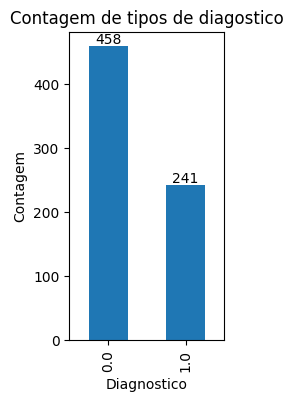

In [26]:
#Contagem de diagonosticos
diag_counts = data['diagnostico'].value_counts()

#Plota grafico de barra
plt.figure(figsize=(2,4))
diag_counts.plot(kind='bar')
plt.xlabel("Diagnostico")
plt.ylabel("Contagem")
plt.title("Contagem de tipos de diagostico")

#adiciona os rotulos
for i, count in enumerate(diag_counts):
   plt.text(i, count, str(count), ha ="center", va="bottom")
   
plt.show()

### 4.1 Sumarização estatística

In [27]:
def sumarizacao(data):
   stats = []
   
   for column in x_names:
      values = data[column]
      maximun = round(values.max(), 2)
      minimun = round(values.min(), 2)
      mean = round(values.mean(), 2)
      median = round(values.median(), 2)
      std = round(values.std(), 2)
      stats.append([column, maximun, minimun, mean, median, std])
      
   headers = ['Coluna', "Máximo", "Mínimo", "Média", "Mediana", "Desvio Padrão"]
   
   table = tabulate(stats, headers, tablefmt='pipe')
   print(table)
   
sumarizacao(data)

| Coluna         |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:---------------|---------:|---------:|--------:|----------:|----------------:|
| espessura      |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula     |       10 |        1 |    3.13 |         1 |            3.05 |
| forma_celula   |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao         |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial  |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus    |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina      |       10 |        1 |    3.44 |         3 |            2.44 |
| nuclos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses        |       10 |        1 |    1.59 |         1 |            1.72 |


['espessura', 'tam_celula', 'forma_celula', 'adesao', 'tam_epitelial', 'nucleos_nus', 'cromatina', 'nuclos_normais', 'mitoses']


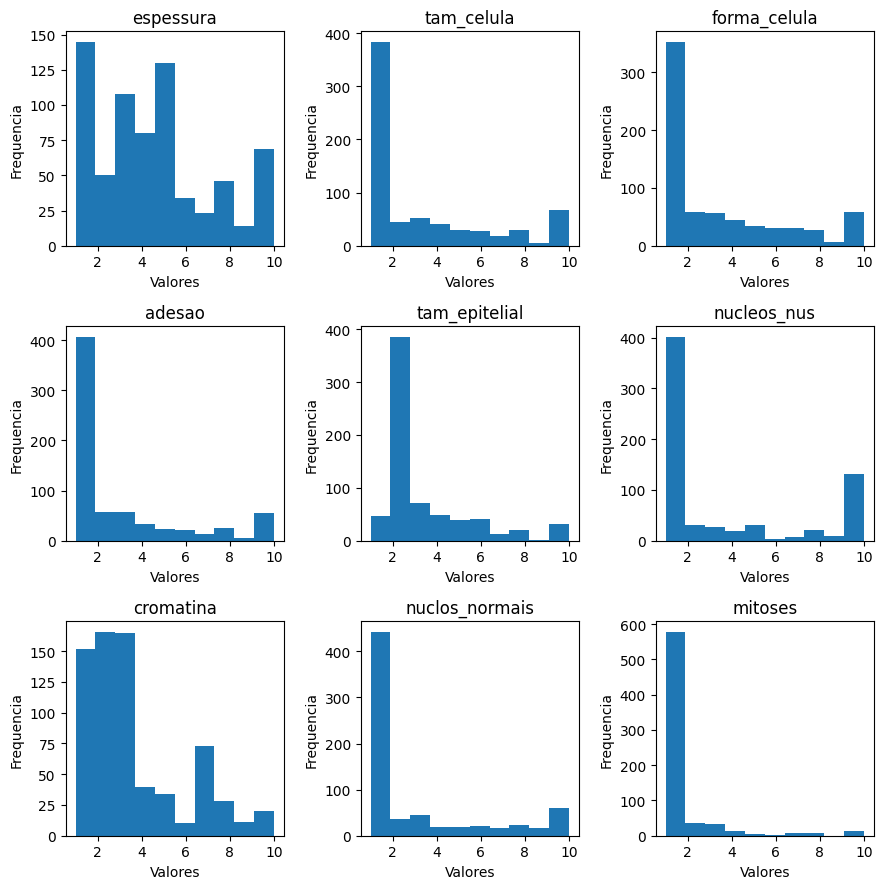

In [28]:
print(x_names)

fig, axs = plt.subplots(3,3, figsize=(9,9), tight_layout=True)

for i, column in enumerate(x_names):
   row = i//3
   col = i%3
   axs[row, col].hist(data[column], bins=10)
   axs[row, col].set_title(column)
   axs[row, col].set_xlabel("Valores")
   axs[row, col].set_ylabel("Frequencia")
   
plt.show()
   

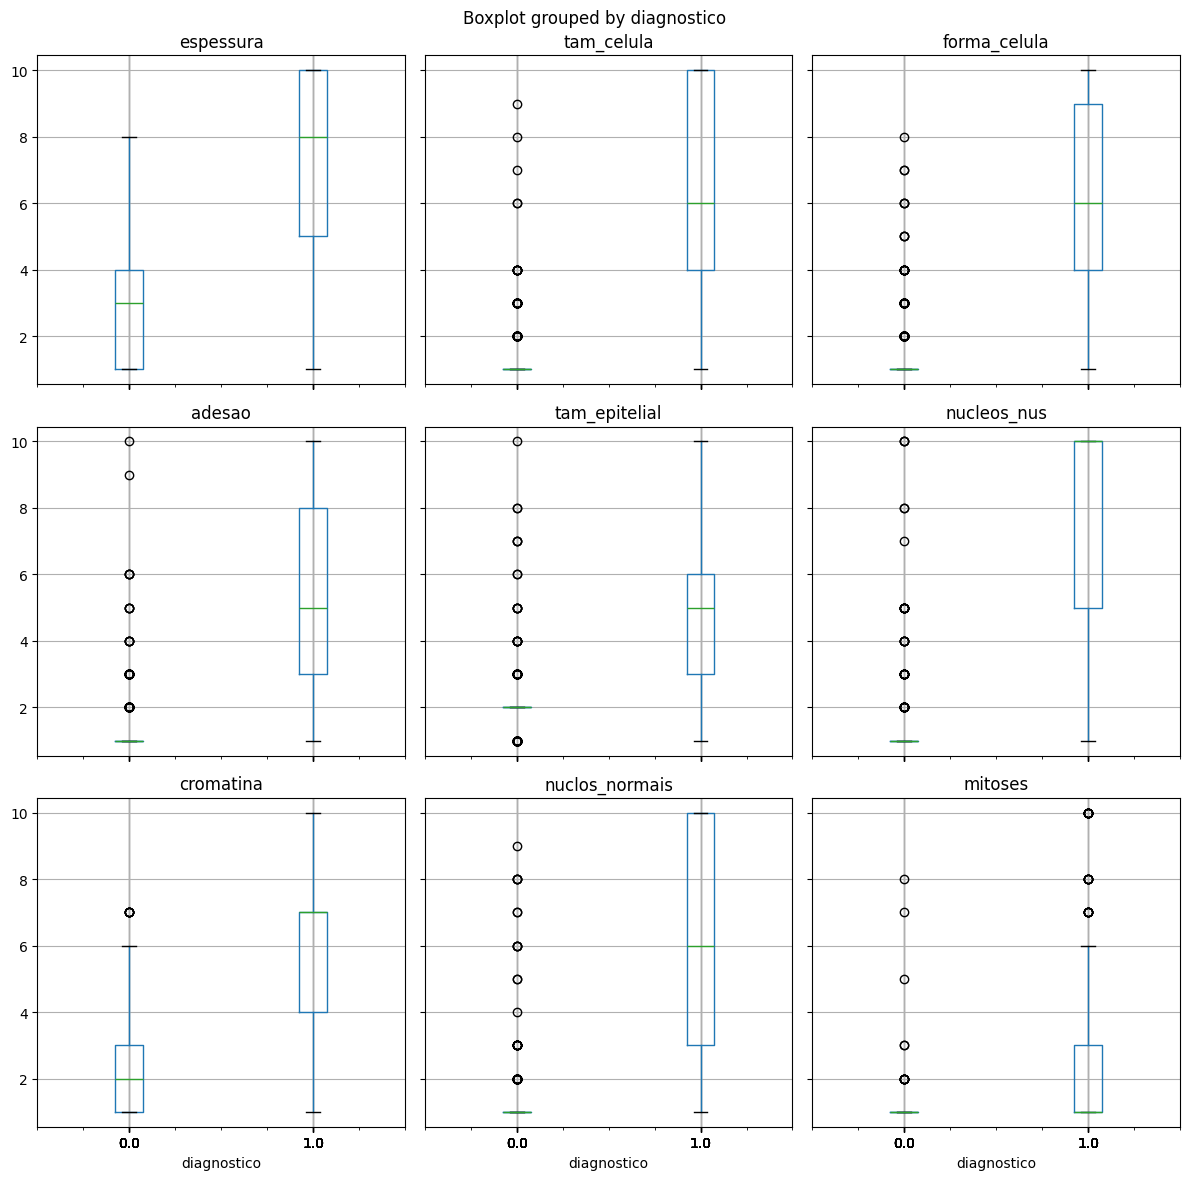

In [29]:
data.boxplot(column=x_names, by='diagnostico', figsize=(12,12))
plt.tight_layout()
plt.show()

### 4.2 Detecçao de Dados Faltantes e Interpolação

In [30]:
misssign_counts = data.isnull().sum()
print('Total de dados faltantes por coluna:', misssign_counts)

Total de dados faltantes por coluna: espessura          0
tam_celula         0
forma_celula       0
adesao             0
tam_epitelial      0
nucleos_nus       16
cromatina          0
nuclos_normais     0
mitoses            0
diagostico         0
diagnostico        0
dtype: int64


In [31]:
#interpola os dados faltantes
def interpolacao(data):
   if data.isnull().values.any():
      points_inds_danger = [0,1, len(data)-2, len(data)-1]
      for colname in x_names:
         for ind_danger in points_inds_danger:
            if np.isnan(data[colname].iloc[ind_danger].astype(float)):
               data[colname].iloc[ind_danger] = data[colname].mean()
         
         data[colname] = data[colname].interpolate(method='nearest').copy()
         
   return data

In [32]:
if interp_exec:
   
   data = interpolacao(data)

   misssign_counts = data.isnull().sum()
   print('Total de dados faltantes por coluna:', misssign_counts)

Total de dados faltantes por coluna: espessura         0
tam_celula        0
forma_celula      0
adesao            0
tam_epitelial     0
nucleos_nus       0
cromatina         0
nuclos_normais    0
mitoses           0
diagostico        0
diagnostico       0
dtype: int64


### 4.3 Detecção e Substituição dos outliers

In [33]:
def getQuantiles(x, margin = 1.5, low = 0.1, high = 0.9):
   q1 = x.quantile(low)
   q3 = x.quantile(high)
   iqr = q3 - q1
   fence_low = q1 - (margin*iqr)
   fence_high = q3 + (margin*iqr)
   
   return [fence_low, fence_high]

def replaceOutliers(serie, m):
   x = serie.copy()
   fences = getQuantiles(x, margin=m)
   bad_ind = x.loc[(x < fences[0]) | (x > fences[1])].index
   x[bad_ind] = np.nan
   
   outlier_inds_danger = [0,1, len(serie)-2, len(serie)-1]
   for ind_danger in outlier_inds_danger:
      if np.isnan(x.iloc[ind_danger]):
         x[ind_danger] = (fences[0] + fences[1])/2
   
   if x.isnull().values.any():
      x = x.interpolate(method='nearest').copy()
      
   return x

In [34]:
if outliers_exec:
   for col in x_names:
      data[col] = replaceOutliers(data[col], 0)

### 4.4 Normalização

In [35]:
def normalization(data, method):
   if method == 'asinh':
      return np.arcsinh(data)
   elif method == 'log':
      return np.log(data)
   else: 
      return (data - np.mean(data))/np.std(data)
   
   

In [36]:
if normalization_exec:
   for col in x_names:
      data[col] = normalization(data[col], 'log')

### 4.5 Escalonamento

In [39]:
def create_support_col(minvalue, maxvalue, sizecol):
   minvalue = [minvalue] * round(sizecol/2)
   maxvalues = [maxvalue] * (sizecol - round(sizecol/2))
   return[*minvalue, *maxvalues]

def minMaxIndividual(df, col, minvalue, maxvalue, rgint):
   serie = df[col].copy()
   # cria uma regua com um valor minimo e maximo previamente determinadao
   # FUCK Col suport 
   serie['support'] = create_support_col(minvalue, maxvalue, len(serie))
   
   #escalona considerando o minimo e o maximo especificado
   tmp = serie.to_numpy().reshape(-1,1)
   
   #cria o objeto de escalonamento
   minmaxscaler = preprocessing.MinMaxScaler(feature_range=rgint).fit(tmp)
   
   #cria os dados escalonados
   scaled = minmaxscaler.transform(tmp).reshape(serie.shape[0], serie.shape[1])
   
   #remove a coluna de suporte e atualiza as colunas escalonadas no dataset
   df[col] = scaled[:, 0:(scaled.shape[1]-1)]
   
   return df
   

In [40]:
if scale_exec:
   scale_range = (0, 1)
   for col in x_names:
      data = minMaxIndividual(data, [col], np.min(data[col]), np.max(data[col]), scale_range)

### 4.6 Exportando ou carregando um dataset tratado

In [45]:
if export_frames:
   bar = progressbar.ProgressBar(maxval=len(data), widgets=[progressbar.Bar("=", "[", "]", " ", progressbar.Percentage)])
   bar.start()
   
   x_frames = []
   y_frames = []
   
   cont = 0
   for ind in range(0, len(data)):
      x_frames.append(data.loc[ind, x_names].values)
      y_frames.append(data.loc[ind, y_names].values.reshape(-1))
      
      bar.update(cont + 1)
      cont += 1
   
   x_frames = np.array(x_frames)
   y_frames = np.array(y_frames).reshape(-1,1)
   
   dump(x_frames, 'dataset/x_frames.joblib')
   dump(y_frames, 'dataset/y_frames.joblib')
   
   bar.finish()
   
else: 
   x_frames = load('dataset/x_frames.joblib')
   y_frames = load('dataset/y_frames.joblib')
   
print(x_frames.shape)
print(y_frames.shape)


   

(699, 9)
(699, 1)
